## Optimizer-ek összehasonlítása MSE-loss mellett (10 epoch)



In [1]:
#%% 1. Setup és adatok
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from complex_mlp.model import ComplexMLP

# Adat betöltése
data = np.load("../data/processed/dataset_preProcessed.npz")
X = data["images"].reshape(len(data["images"]), -1) / 255.0
y = data["labels"]

# Train/val split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Paraméterek
input_dim   = X_tr.shape[1]
n_classes   = len(np.unique(y_tr))
layer_sizes = [input_dim, 512, n_classes]
activations = ["tanh", "softmax"]

# One-hot MSE-hez
y_tr_hot  = np.eye(n_classes)[y_tr]
y_val_hot = np.eye(n_classes)[y_val]


In [2]:
#%% 2. Optimizer konfigurációk
optimizer_configs = {
    "SGD": {
        "optimizer": "sgd",
        "optimizer_kwargs": {"lr": 0.001}
    },
    "Momentum": {
        "optimizer": "momentum",
        "optimizer_kwargs": {"lr": 0.001, "momentum": 0.9}
    },
    "RMSProp": {
        "optimizer": "rmsprop",
        "optimizer_kwargs": {"lr": 0.001, "beta": 0.9, "eps": 1e-8}
    },
    "Adam": {
        "optimizer": "adam",
        "optimizer_kwargs": {"lr": 0.001, "beta1": 0.9, "beta2": 0.999, "eps": 1e-8}
    }
}


In [3]:
#%% 3. Futtató ciklus
results = []

for name, cfg in optimizer_configs.items():
    print(f"--- Teszt: {name} ---")
    model = ComplexMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss="mse",
        optimizer=cfg["optimizer"],
        optimizer_kwargs=cfg["optimizer_kwargs"],
        early_stopping=False
    )
    history = model.train(
        X_train=X_tr, y_train=y_tr_hot,
        X_val=X_val,   y_val=y_val_hot,
        epochs=10, batch_size=32
    )
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} → val_accuracy = {acc:.4f}\n")
    results.append({
        "optimizer": name,
        "val_accuracy": acc
    })

df = pd.DataFrame(results).sort_values("val_accuracy", ascending=False)
display(df)


--- Teszt: SGD ---
Epoch 1/10  train_loss=0.0378  val_loss=0.0287
Epoch 2/10  train_loss=0.0240  val_loss=0.0201
Epoch 3/10  train_loss=0.0189  val_loss=0.0172
Epoch 4/10  train_loss=0.0171  val_loss=0.0164
Epoch 5/10  train_loss=0.0162  val_loss=0.0157
Epoch 6/10  train_loss=0.0157  val_loss=0.0154
Epoch 7/10  train_loss=0.0154  val_loss=0.0151
Epoch 8/10  train_loss=0.0152  val_loss=0.0147
Epoch 9/10  train_loss=0.0149  val_loss=0.0149
Epoch 10/10  train_loss=0.0148  val_loss=0.0146
SGD → val_accuracy = 0.9072

--- Teszt: Momentum ---
Epoch 1/10  train_loss=0.0379  val_loss=0.0286
Epoch 2/10  train_loss=0.0239  val_loss=0.0202
Epoch 3/10  train_loss=0.0188  val_loss=0.0173
Epoch 4/10  train_loss=0.0170  val_loss=0.0165
Epoch 5/10  train_loss=0.0162  val_loss=0.0159
Epoch 6/10  train_loss=0.0157  val_loss=0.0157
Epoch 7/10  train_loss=0.0154  val_loss=0.0149
Epoch 8/10  train_loss=0.0152  val_loss=0.0150
Epoch 9/10  train_loss=0.0150  val_loss=0.0146
Epoch 10/10  train_loss=0.0148  va

,optimizer,val_accuracy
3,Adam,0.947718
2,RMSProp,0.937232
1,Momentum,0.907178
0,SGD,0.907178


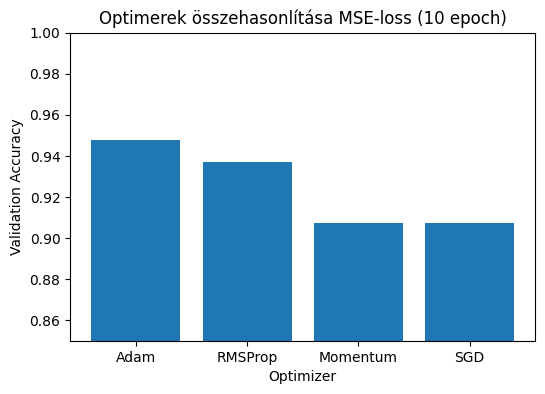

In [8]:
#%% 4. Eredmények ábrázolása
plt.figure(figsize=(6,4))
plt.bar(df["optimizer"], df["val_accuracy"])
plt.xlabel("Optimizer")
plt.ylabel("Validation Accuracy")
plt.title("Optimerek összehasonlítása MSE-loss (10 epoch)")
plt.ylim(0.85,1)
plt.show()
